In [1]:
import rasterio
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pandas as pd

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
from geopandas import GeoDataFrame
from shapely import wkt
import rioxarray as rxr
import fiona

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

In [4]:
hpi = gpd.read_file('data/HPI_Map_2021_11_03.geojson')

In [5]:
hpi_la = hpi[hpi.County_Name=='Los Angeles']

In [6]:
hpi_la

,CensusTract,pop2010,pct2010gq,City,ZIP,County_FIPS,County_Name,UrbanType,hpi2score,hpi2_pctile_pos,...,black_pct,asian_pct,latino_pct,multiple_pct,NativeAm_pct,PacificIsl_pct,other_pct,version,notes,geometry
0,6037139301,4462,1.6,Los Angeles,91356,6037,Los Angeles,urban_area,0.176188988,60.36186321,...,3.585835948,6.633796504,9.547288212,3.697893321,0.134468848,0.224114747,0.044822949,Wed13Dec17,,"MULTIPOLYGON (((-118.57150 34.17758, -118.5714..."
1,6037139302,4422,2.3,Los Angeles,91356,6037,Los Angeles,urban_area,-0.5976217,15.52675478,...,9.249208503,9.226594301,27.06919946,4.274084125,0.293984622,0.226142017,0.248756219,Wed13Dec17,,"MULTIPOLYGON (((-118.54073 34.18019, -118.5407..."
2,6037139502,3007,0.3,Los Angeles,91316,6037,Los Angeles,urban_area,0.248733799,64.87873733,...,1.529763884,5.054871965,8.613235783,7.016960426,0,0.19953442,0.266045893,Wed13Dec17,,"MULTIPOLYGON (((-118.53225 34.16201, -118.5317..."
3,6037139600,4633,0,Los Angeles,91316,6037,Los Angeles,urban_area,0.448743211,77.21031695,...,3.669328729,6.345780272,8.482624649,3.626160155,0.151090006,0.12950572,0.021584287,Wed13Dec17,,"MULTIPOLYGON (((-118.51858 34.15858, -118.5185..."
4,6037139701,4920,1.5,Los Angeles,91436,6037,Los Angeles,urban_area,0.755946854,91.63351726,...,1.849593496,5.833333333,6.483739837,2.398373984,0.06097561,0.06097561,0.162601626,Wed13Dec17,,"MULTIPOLYGON (((-118.50980 34.15691, -118.5084..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,6037192700,3513,10.2,Los Angeles,90004,6037,Los Angeles,urban_area,-0.58135518,16.32234056,...,4.981497296,23.74039283,59.35098207,1.394819243,0.256191289,0.199259892,0.142328494,Wed13Dec17,,"MULTIPOLYGON (((-118.29171 34.08359, -118.2905..."
8049,6037194500,2037,3.2,Los Angeles,90048,6037,Los Angeles,urban_area,0.255104821,65.31502631,...,1.865488463,6.627393225,5.30191458,2.994599902,0.049091802,0,0.29455081,Wed13Dec17,,"MULTIPOLYGON (((-118.37880 34.07639, -118.3786..."
8050,6037195100,4717,5.3,Los Angeles,90039,6037,Los Angeles,urban_area,0.626142938,86.39804953,...,3.13758745,16.1755353,14.24634301,3.75238499,0.04239983,0.148399406,0.233199067,Wed13Dec17,,"MULTIPOLYGON (((-118.27691 34.09584, -118.2768..."
8051,6037195300,3203,0.2,Los Angeles,90027,6037,Los Angeles,urban_area,0.337343276,70.48633389,...,1.717140181,13.79956291,30.37777084,2.591320637,0.218545114,0,0.187324383,Wed13Dec17,,"MULTIPOLYGON (((-118.29177 34.10178, -118.2895..."


In [7]:
pd.to_numeric(hpi['hpi2score'], errors = 'coerce').fillna(0)

0       0.176189
1      -0.597622
2       0.248734
3       0.448743
4       0.755947
          ...   
8052    0.359985
8053    0.248324
8054    0.921108
8055    0.719240
8056    0.207374
Name: hpi2score, Length: 8057, dtype: float64

In [8]:
v1 = hpi_la[['ZIP','pop2010', 'CensusTract','hpi2score','geometry']]

In [9]:
v1['vul'] = pd.to_numeric(v1['hpi2score'], errors = 'coerce')

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
v1['pop2010'] = pd.to_numeric(v1['pop2010'], errors = 'coerce')

In [11]:
v = v1.drop(['hpi2score'], axis = 1)
v

,ZIP,pop2010,CensusTract,geometry,vul
0,91356,4462,6037139301,"MULTIPOLYGON (((-118.57150 34.17758, -118.5714...",0.176189
1,91356,4422,6037139302,"MULTIPOLYGON (((-118.54073 34.18019, -118.5407...",-0.597622
2,91316,3007,6037139502,"MULTIPOLYGON (((-118.53225 34.16201, -118.5317...",0.248734
3,91316,4633,6037139600,"MULTIPOLYGON (((-118.51858 34.15858, -118.5185...",0.448743
4,91436,4920,6037139701,"MULTIPOLYGON (((-118.50980 34.15691, -118.5084...",0.755947
...,...,...,...,...,...
8048,90004,3513,6037192700,"MULTIPOLYGON (((-118.29171 34.08359, -118.2905...",-0.581355
8049,90048,2037,6037194500,"MULTIPOLYGON (((-118.37880 34.07639, -118.3786...",0.255105
8050,90039,4717,6037195100,"MULTIPOLYGON (((-118.27691 34.09584, -118.2768...",0.626143
8051,90027,3203,6037195300,"MULTIPOLYGON (((-118.29177 34.10178, -118.2895...",0.337343


### Conversion for overlay on OpenStreeMap

In [12]:
vul_wm = v.to_crs(epsg=3857)

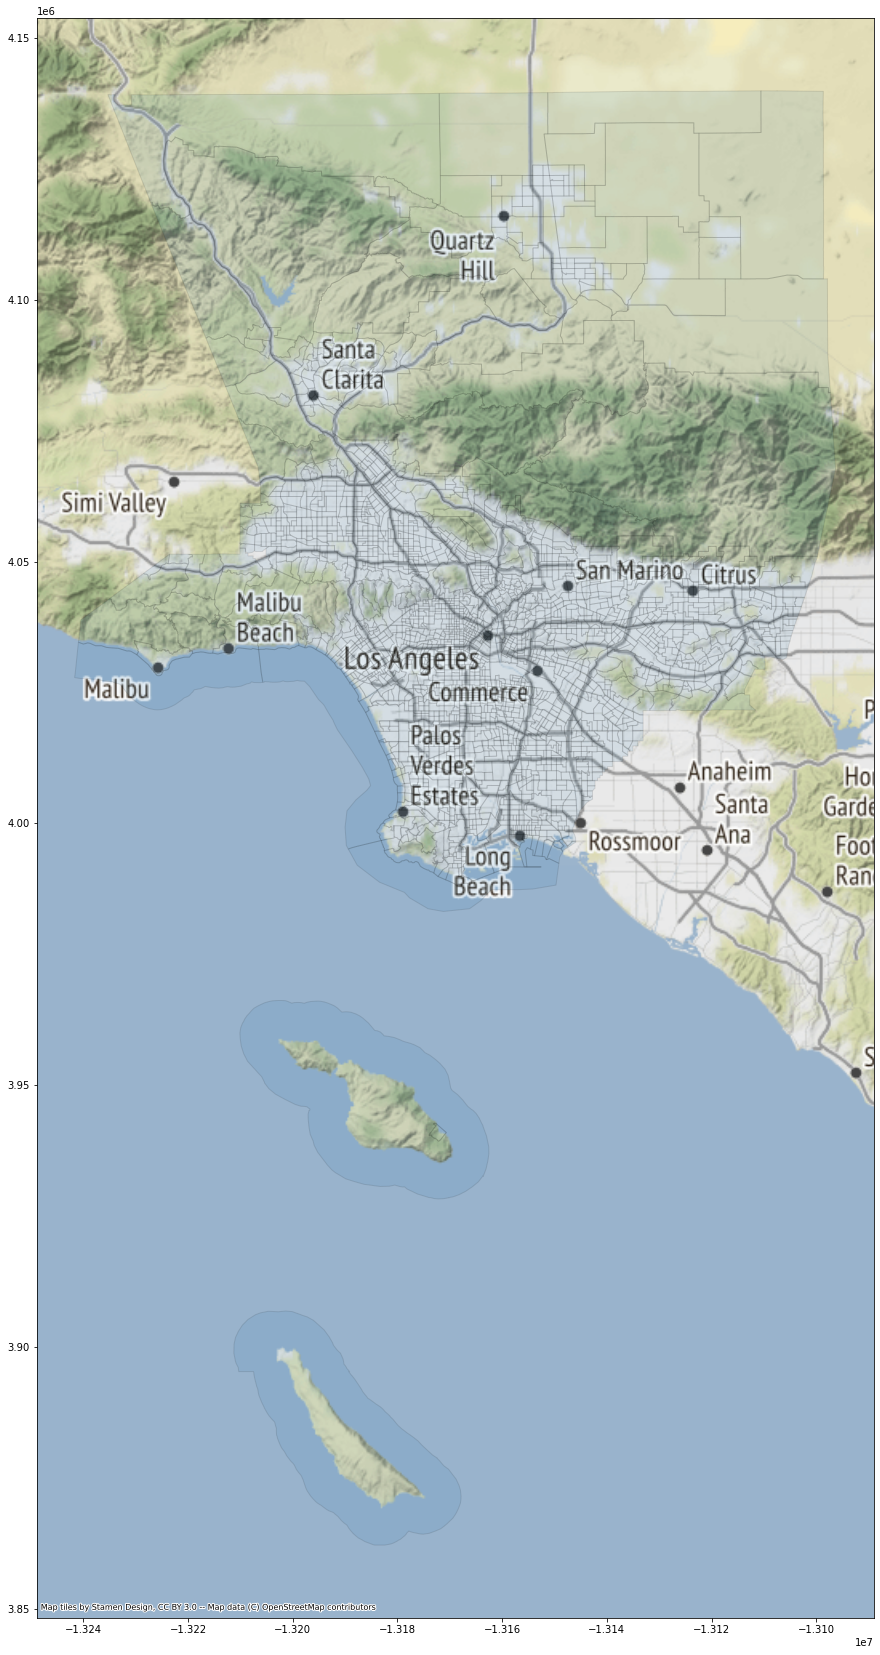

In [13]:
ax = vul_wm.plot(figsize=(15, 45), alpha=0.1, edgecolor='k')
cx.add_basemap(ax)

<AxesSubplot:>

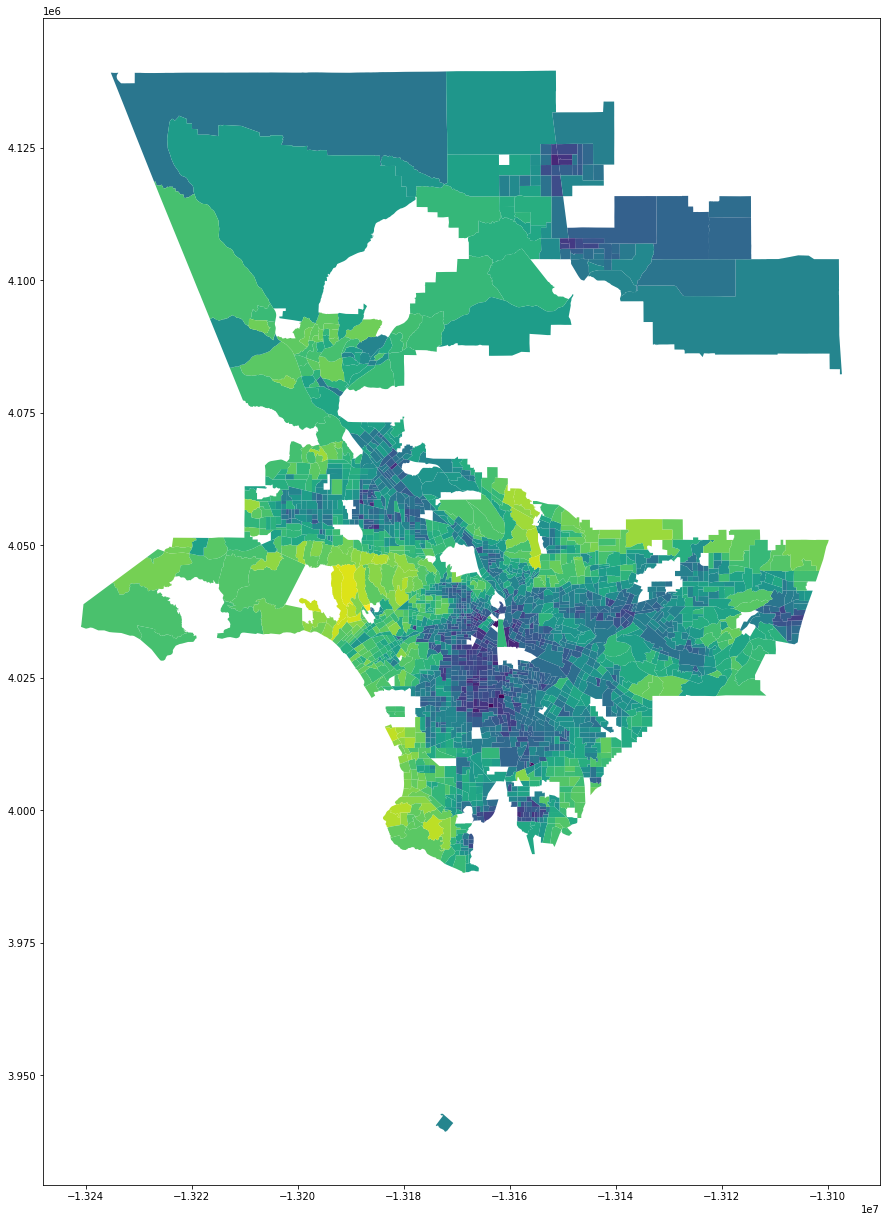

In [14]:
vul_wm.plot(column='vul', categorical=False, figsize=(15, 45), legend=False)

## Import geopandas dataframes 

In [15]:
tr_demstats = gpd.GeoDataFrame.from_file('data/out/tracts_demstats.geojson')

In [16]:
tr_impvstats = gpd.GeoDataFrame.from_file('data/out/tracts_impvstats.geojson')

In [17]:
tr_landstats = gpd.GeoDataFrame.from_file('data/out/tracts_landstats.geojson')

In [18]:
tr_treestats = gpd.GeoDataFrame.from_file('data/out/tracts_treestats.geojson')

In [19]:
tr_treestats.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### Join geopandas dataframes together to eventually get v + i in the same dataframe for cluster analysis

In [20]:
result1 = pd.merge(tr_demstats, tr_impvstats, how = 'inner', on = 'GEOID', sort = False, copy = True,
                  indicator = False, validate = None)

In [21]:
result2 = pd.merge(tr_landstats, tr_treestats, how = 'inner', on = 'GEOID', sort = False, copy = True,
                   indicator = False, validate = None)

In [22]:
result3 = pd.merge(result1, result2, how = 'inner', on = 'GEOID', sort = False, copy = True,
                  indicator = False, validate = None)

In [23]:
result3

,STATEFP_x_x,COUNTYFP_x_x,TRACTCE_x_x,GEOID,NAME_x_x,NAMELSAD_x_x,MTFCC_x_x,FUNCSTAT_x_x,ALAND_x_x,AWATER_x_x,...,FUNCSTAT_y_y,ALAND_y_y,AWATER_y_y,INTPTLAT_y_y,INTPTLON_y_y,tree_min,tree_max,tree_mean,tree_median,geometry_y_y
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,...,S,337352192,1098469237,+32.9255700,-118.4972902,0.0,53.0,0.215304,0.0,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165..."
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,...,S,3166634,0,+33.9002308,-117.9684399,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765..."
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,...,S,76355354,30155,+34.8432832,-118.9897489,0.0,0.0,0.000000,0.0,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847..."
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,...,S,3006590,4374,+34.1661153,-118.6402345,0.0,47.0,8.745668,6.0,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584..."
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,...,S,872792,0,+33.8993442,-118.2100023,0.0,12.0,1.401094,0.0,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,...,S,1070644,0,+34.1112603,-118.3297989,0.0,42.0,9.065780,8.0,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369..."
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,...,S,1446823,0,+34.1200812,-118.3211428,0.0,45.0,14.083056,12.0,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267..."
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,...,S,879184,0,+34.1367194,-118.2088736,0.0,37.0,4.293796,0.0,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173..."
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,...,S,1592982,15869,+33.9408240,-117.9410039,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330..."


In [24]:
i1 = result3[['TRACTCE_x_x', 'GEOID', 'NAME_x_x', 'INTPTLAT_y_y', 
              'INTPTLON_y_y', 'tree_mean', 'land_majority', 'impv_mean', 'dem_mean', 'geometry_y_y']]

In [25]:
i = i1.rename(columns ={'TRACTCE_x_x': 'TRACTCE', 'NAME_x_x': 'NAME', 'INTPTLAT_y_y': 'INTPTLAT', 
                       'INTPTLON_y_y': 'INTPTLON', 'geometry_y_y': 'geometry' })

In [26]:
i

,TRACTCE,GEOID,NAME,INTPTLAT,INTPTLON,tree_mean,land_majority,impv_mean,dem_mean,geometry
0,599100,06037599100,5991,+32.9255700,-118.4972902,0.215304,52.0,0.956937,226.110165,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165..."
1,001710,06059001710,17.10,+33.9002308,-117.9684399,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765..."
2,003308,06029003308,33.08,+34.8432832,-118.9897489,0.000000,22.0,44.066667,1184.747640,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847..."
3,137000,06037137000,1370,+34.1661153,-118.6402345,8.745668,22.0,45.807251,281.206176,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584..."
4,541605,06037541605,5416.05,+33.8993442,-118.2100023,1.401094,23.0,71.759344,21.508713,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153..."
...,...,...,...,...,...,...,...,...,...,...
2528,189600,06037189600,1896,+34.1112603,-118.3297989,9.065780,23.0,45.360680,175.437523,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369..."
2529,189400,06037189400,1894,+34.1200812,-118.3211428,14.083056,22.0,30.447398,237.594161,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267..."
2530,181400,06037181400,1814,+34.1367194,-118.2088736,4.293796,23.0,62.925182,182.338486,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173..."
2531,001401,06059001401,14.01,+33.9408240,-117.9410039,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330..."


In [27]:
i.to_csv(r'data/out/infra.csv')

In [28]:
v.to_csv(r'data/out/v.csv')

### Import gpd following cluster analysis

In [29]:
cl_results0 = gpd.read_file('data/out/results0.geojson')
cl_results0

,GEOID,ZIP,tree_mean,land_majority,impv_mean,dem_mean,vul,pop2010,cluster,geometry
0,6037599100,90704.0,0.215304,52.0,0.956937,226.110165,NaN,527.0,1,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165..."
1,6029003308,NaN,0.000000,22.0,44.066667,1184.747640,NaN,NaN,3,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847..."
2,6037137000,NaN,8.745668,22.0,45.807251,281.206176,NaN,NaN,3,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584..."
3,6037541605,90221.0,1.401094,23.0,71.759344,21.508713,-0.585446,5323.0,2,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153..."
4,6037541801,90262.0,2.277339,23.0,65.446449,24.308732,-0.516531,4903.0,0,"MULTIPOLYGON (((-118.19998 33.90668, -118.1987..."
...,...,...,...,...,...,...,...,...,...,...
2512,6037480902,91803.0,0.971383,23.0,78.041335,138.571439,-0.129946,4218.0,2,"MULTIPOLYGON (((-118.14496 34.08080, -118.1447..."
2513,6037189600,90068.0,9.065780,23.0,45.360680,175.437523,-0.215253,3529.0,3,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369..."
2514,6037189400,90068.0,14.083056,22.0,30.447398,237.594161,0.508082,3448.0,3,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267..."
2515,6037181400,90041.0,4.293796,23.0,62.925182,182.338486,0.239630,4302.0,0,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173..."


In [30]:
cl_results1 = gpd.read_file('data/out/results1.geojson')

In [31]:
cl_results1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Add census tract area as a variable

In [32]:
areas0 = cl_results0.to_crs({'proj':'cea'})
areas0['area'] = cl_results0['geometry'].area*10000
areas0.head(5)

/var/folders/22/w9k9dn754d7bwv89pbvgxw080000gn/T/ipykernel_54865/488321511.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas0['area'] = cl_results0['geometry'].area*10000


,GEOID,ZIP,tree_mean,land_majority,impv_mean,dem_mean,vul,pop2010,cluster,geometry,area
0,6037599100,90704.0,0.215304,52.0,0.956937,226.110165,NaN,527.0,1,"MULTIPOLYGON (((-13182078.816 3436047.287, -13...",142.675853
1,6029003308,NaN,0.000000,22.0,44.066667,1184.747640,NaN,NaN,3,"MULTIPOLYGON (((-13234723.479 3622619.977, -13...",0.008606
2,6037137000,NaN,8.745668,22.0,45.807251,281.206176,NaN,NaN,3,"MULTIPOLYGON (((-13209016.934 3563450.434, -13...",2.943936
3,6037541605,90221.0,1.401094,23.0,71.759344,21.508713,-0.585446,5323.0,2,"MULTIPOLYGON (((-13159778.097 3538787.933, -13...",0.850721
4,6037541801,90262.0,2.277339,23.0,65.446449,24.308732,-0.516531,4903.0,0,"MULTIPOLYGON (((-13157961.474 3539090.574, -13...",0.696960


In [33]:
areas1 = cl_results1.to_crs({'proj':'cea'})
areas1['area'] = cl_results1['geometry'].area*10000
areas1.head(5)

/var/folders/22/w9k9dn754d7bwv89pbvgxw080000gn/T/ipykernel_54865/4178980629.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas1['area'] = cl_results1['geometry'].area*10000


,GEOID,tree_mean,land_majority,impv_mean,dem_mean,vul,pop2010,cluster,geometry,area
0,6037541605,1.401094,23.0,71.759344,21.508713,-0.585446,5323,3,"MULTIPOLYGON (((-13159778.097 3538787.933, -13...",0.850721
1,6037541801,2.277339,23.0,65.446449,24.308732,-0.516531,4903,3,"MULTIPOLYGON (((-13157961.474 3539090.574, -13...",0.696960
2,6037541802,2.123907,23.0,63.546647,24.440263,-0.426446,5431,3,"MULTIPOLYGON (((-13157250.254 3539078.133, -13...",1.082185
3,6037542000,2.488353,23.0,62.310316,22.896972,-0.498291,5732,1,"MULTIPOLYGON (((-13158780.563 3539149.921, -13...",0.949467
4,6037573800,4.685759,23.0,56.614293,9.985991,0.458502,4284,0,"MULTIPOLYGON (((-13147834.072 3531017.841, -13...",1.493933


##### Join area variable to main geopandas df

In [34]:
cl_results0_areas = pd.merge(cl_results0,areas0[['GEOID','area']],on='GEOID', how='left')

In [35]:
cl_results1_areas = pd.merge(cl_results1,areas1[['GEOID','area']],on='GEOID', how='left')

##### Slightly random, but building a legend dict for the land classes

In [36]:
bins = [0,11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95]

In [37]:
valueslst = ['NaN','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, Low Intensity',
           'Developed, Medium Intensity','Developed High Intensity','Barren Land (Rock/Sand/Clay)',
           'Deciduous Forest','Evergreen Forest','Mixed Forest','Dwarf Scrub','Shrub/Scrub',
           'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss','Pasture/Hay','Cultivated Crops',
           'Woody Wetlands','Emergent Herbaceous Wetlands']

In [38]:
leg_zip = zip(bins, valueslst)
leg_dict = dict(leg_zip)
type(leg_dict)

dict

In [39]:
cl_results0_areas['land_majority'].value_counts()

23.0    1645
24.0     486
22.0     191
52.0     138
21.0      27
71.0      21
81.0       6
31.0       1
82.0       1
95.0       1
Name: land_majority, dtype: int64

In [40]:
cl_results1_areas['land_majority'].value_counts()

23.0    1338
24.0     366
22.0     151
52.0      89
71.0      12
21.0      10
81.0       2
Name: land_majority, dtype: int64

In [41]:
coverage0 = (cl_results0_areas['area'].agg(['sum']))/10510
coverage0

sum    0.968248
Name: area, dtype: float64

In [42]:
coverage1 = (cl_results1_areas['area'].agg(['sum']))/10510
coverage1

sum    0.486421
Name: area, dtype: float64

In [43]:
cl_results0_areas.groupby('cluster').agg(['count', 'min', 'max','mean'])['pop2010']

,count,min,max,mean
cluster,,,,
0,803,0.0,9344.0,4246.775841
1,159,0.0,7377.0,3780.522013
2,694,0.0,7883.0,3929.151297
3,361,0.0,7720.0,4152.831025


In [44]:
cl_results1_areas.groupby('cluster').agg(['count', 'min', 'max','mean'])['pop2010']

,count,min,max,mean
cluster,,,,
0,701,3307,4444,3883.980029
1,244,5654,7720,6294.963115
2,532,1512,3303,2725.278195
3,491,4447,5647,5005.101833


In [45]:
cl_results0_areas.groupby('cluster').agg(['count', 'min', 'mean'])['impv_mean']

,count,min,mean
cluster,,,
0,987,53.625150,63.524748
1,227,0.000000,14.364206
2,847,71.332982,79.186436
3,456,29.506219,44.398678


In [46]:
cl_results1_areas.groupby('cluster').agg(['count', 'min', 'mean'])['impv_mean']

,count,min,mean
cluster,,,
0,701,0.645377,63.459058
1,244,0.471028,57.155696
2,532,0.741799,62.195638
3,491,6.815864,62.610069


### Favoring results0, particularly as the area clustered is 97% of LA County

##### First, take care of some business by adding land classification labels to cl_results0_area dataframe

In [47]:
cl_results0_areas['land_class'] = cl_results0_areas['land_majority'].map(leg_dict)
type(cl_results0_areas)

geopandas.geodataframe.GeoDataFrame

#### What surface area designated as developed?

In [48]:
land_cover = cl_results0_areas.groupby('land_class').agg(['count', 'sum'])['area']
land_cover['percent'] = (land_cover['sum']/10510)*100
land_cover

,count,sum,percent
land_class,,,
Barren Land (Rock/Sand/Clay),1,0.035798,0.000341
Cultivated Crops,1,24.321879,0.231417
Developed High Intensity,486,500.216686,4.759436
"Developed, Low Intensity",191,453.678315,4.316635
"Developed, Medium Intensity",1645,1788.534028,17.017450
"Developed, Open Space",27,123.903147,1.178907
Emergent Herbaceous Wetlands,1,5.107752,0.048599
Grassland/Herbaceous,21,339.853771,3.233623
Pasture/Hay,6,61.088094,0.581238


Text(0, 0.5, 'Percentage')

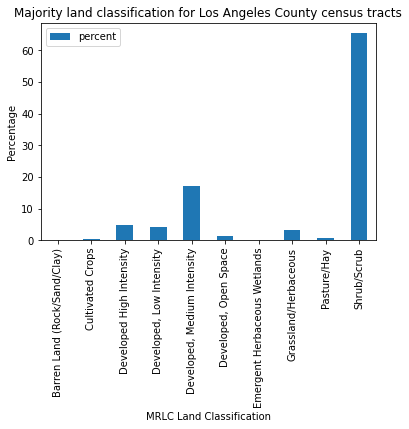

In [49]:
land_cover.plot(y = 'percent', kind = 'bar')
plt.title('Majority land classification for Los Angeles County census tracts')
plt.xlabel('MRLC Land Classification')
plt.ylabel('Percentage')

In [50]:
developed = (cl_results0_areas.query('land_majority > 20 & land_majority < 25').agg(['sum'])['area'])/10510
developed

sum    0.272724
Name: area, dtype: float64

In [51]:
dev_medhigh = (cl_results0_areas.query('land_majority == 23 | land_majority == 24').agg(['sum'])['area'])/10510
dev_medhigh

sum    0.217769
Name: area, dtype: float64

#### At what degree of imperviousness will water no longer filtrate the ground? Is there anything about the relationship of tree canopy and imperviousness that might provide some insight?

In [52]:
sns.set()

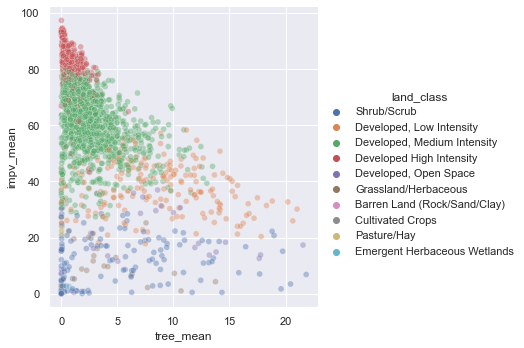

In [53]:
sns.relplot(x='tree_mean', y='impv_mean', hue = 'land_class', alpha = 0.4, data=cl_results0_areas);

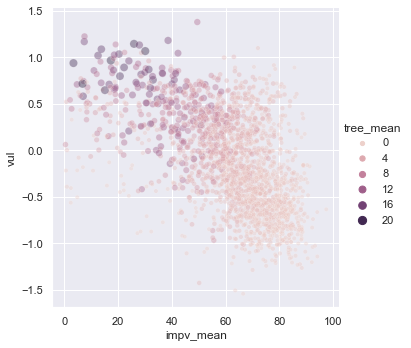

In [54]:
sns.relplot(x='impv_mean', y='vul', hue = 'tree_mean', size = 'tree_mean', alpha = 0.4, data=cl_results0_areas);

In [55]:
results0_pd = cl_results0_areas[['tree_mean', 'impv_mean', 'land_majority', 
                                 'dem_mean', 'vul', 'cluster', 'pop2010', 'area']]
results0_pd = pd.DataFrame(results0_pd)
results0_pd

,tree_mean,impv_mean,land_majority,dem_mean,vul,cluster,pop2010,area
0,0.215304,0.956937,52.0,226.110165,NaN,1,527.0,142.675853
1,0.000000,44.066667,22.0,1184.747640,NaN,3,NaN,0.008606
2,8.745668,45.807251,22.0,281.206176,NaN,3,NaN,2.943936
3,1.401094,71.759344,23.0,21.508713,-0.585446,2,5323.0,0.850721
4,2.277339,65.446449,23.0,24.308732,-0.516531,0,4903.0,0.696960
...,...,...,...,...,...,...,...,...
2512,0.971383,78.041335,23.0,138.571439,-0.129946,2,4218.0,0.501553
2513,9.065780,45.360680,23.0,175.437523,-0.215253,3,3529.0,1.046126
2514,14.083056,30.447398,22.0,237.594161,0.508082,3,3448.0,1.413839
2515,4.293796,62.925182,23.0,182.338486,0.239630,0,4302.0,0.859307


In [56]:
impv_qcut10 = pd.qcut(results0_pd['impv_mean'], 10, labels=range(1,11))

In [57]:
results0_pd['impv_qcut10'] = pd.Series(impv_qcut10, index = results0_pd.index)
impv_decile_trees = results0_pd.groupby('impv_qcut10').agg(['var', 'std', 'mean','max', 'min'])['tree_mean']
impv_decile_trees

,var,std,mean,max,min
impv_qcut10,,,,,
1,34.461034,5.870352,5.812135,21.842774,0.000000
2,19.723867,4.441156,5.876957,20.211030,0.000000
3,7.755185,2.784813,3.924798,14.152174,0.005448
4,4.366716,2.089669,2.925187,11.156109,0.000000
5,2.065864,1.437311,2.179239,8.615282,0.000000
6,1.736380,1.317718,1.788661,9.891414,0.000000
7,1.033955,1.016836,1.478733,6.794304,0.000000
8,0.575388,0.758543,1.195361,4.549346,0.094340
9,0.390601,0.624980,0.968558,3.346154,0.043733


In [58]:
impv_decile_vul = results0_pd.groupby('impv_qcut10').agg(['var', 'std', 'mean','max', 'min'])['vul']
impv_decile_vul

,var,std,mean,max,min
impv_qcut10,,,,,
1,0.203260,0.450844,0.405899,1.222541,-0.892643
2,0.196608,0.443405,0.213089,1.179424,-1.109224
3,0.178228,0.422170,0.056762,1.377370,-1.427645
4,0.139801,0.373899,-0.006805,0.995381,-0.855796
5,0.205880,0.453740,-0.140126,1.002920,-1.507708
6,0.188118,0.433725,-0.240774,0.734055,-1.543588
7,0.216690,0.465500,-0.315914,1.097254,-1.288280
8,0.223251,0.472494,-0.332658,0.803378,-1.243992
9,0.207129,0.455114,-0.448808,0.913241,-1.214726


In [59]:
results0_pd

,tree_mean,impv_mean,land_majority,dem_mean,vul,cluster,pop2010,area,impv_qcut10
0,0.215304,0.956937,52.0,226.110165,NaN,1,527.0,142.675853,1
1,0.000000,44.066667,22.0,1184.747640,NaN,3,NaN,0.008606,2
2,8.745668,45.807251,22.0,281.206176,NaN,3,NaN,2.943936,2
3,1.401094,71.759344,23.0,21.508713,-0.585446,2,5323.0,0.850721,7
4,2.277339,65.446449,23.0,24.308732,-0.516531,0,4903.0,0.696960,6
...,...,...,...,...,...,...,...,...,...
2512,0.971383,78.041335,23.0,138.571439,-0.129946,2,4218.0,0.501553,9
2513,9.065780,45.360680,23.0,175.437523,-0.215253,3,3529.0,1.046126,2
2514,14.083056,30.447398,22.0,237.594161,0.508082,3,3448.0,1.413839,1
2515,4.293796,62.925182,23.0,182.338486,0.239630,0,4302.0,0.859307,5


<AxesSubplot:xlabel='tree_mean', ylabel='impv_qcut10'>

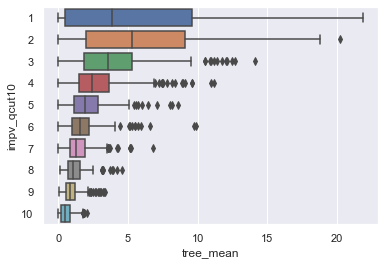

In [60]:
sns.boxplot(x = results0_pd['tree_mean'], y = results0_pd['impv_qcut10'])

<AxesSubplot:xlabel='vul', ylabel='impv_qcut10'>

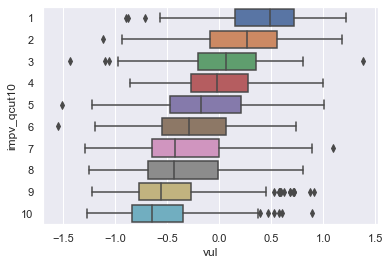

In [61]:
sns.boxplot(x = results0_pd['vul'], y = results0_pd['impv_qcut10'])

<AxesSubplot:xlabel='dem_mean', ylabel='impv_qcut10'>

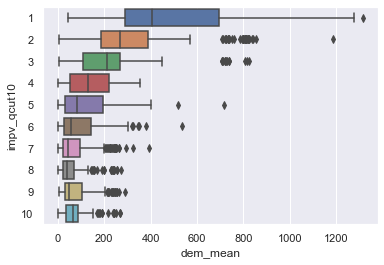

In [62]:
sns.boxplot(x = results0_pd['dem_mean'], y = results0_pd['impv_qcut10'])

## Color tracts by impv_qcut deciles

### Requires adding qcut column back to cl_results0_areas geopandas dataframe!!

In [63]:
cl_results0_areas['impv_qcut10'] = pd.Series(impv_qcut10, index = cl_results0_areas.index)

##### Prep geodataframe for export as geojson; push geometry variable to end, convert categorical variables to float

In [64]:
out0 = cl_results0_areas[['GEOID', 'ZIP', 'tree_mean', 'land_majority', 'impv_mean',
                                             'dem_mean', 'vul', 'pop2010', 'cluster', 'area', 'land_class',
                                             'impv_qcut10', 'geometry']]

In [65]:
out0['cluster'] = pd.to_numeric(out0['cluster'], downcast = 'float')

In [66]:
out0['impv_qcut10'] = pd.to_numeric(out0['impv_qcut10'], downcast = 'float')

In [67]:
gpd_out = gpd.GeoDataFrame(out0, geometry='geometry')

In [68]:
gpd_out.to_file('data/out/gpd_out.geojson', driver='GeoJSON')

/var/folders/22/w9k9dn754d7bwv89pbvgxw080000gn/T/ipykernel_54865/2986127103.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(sm)


<AxesSubplot:title={'center':'Los Angeles Census Tracts by Imperviousness Deciles'}>

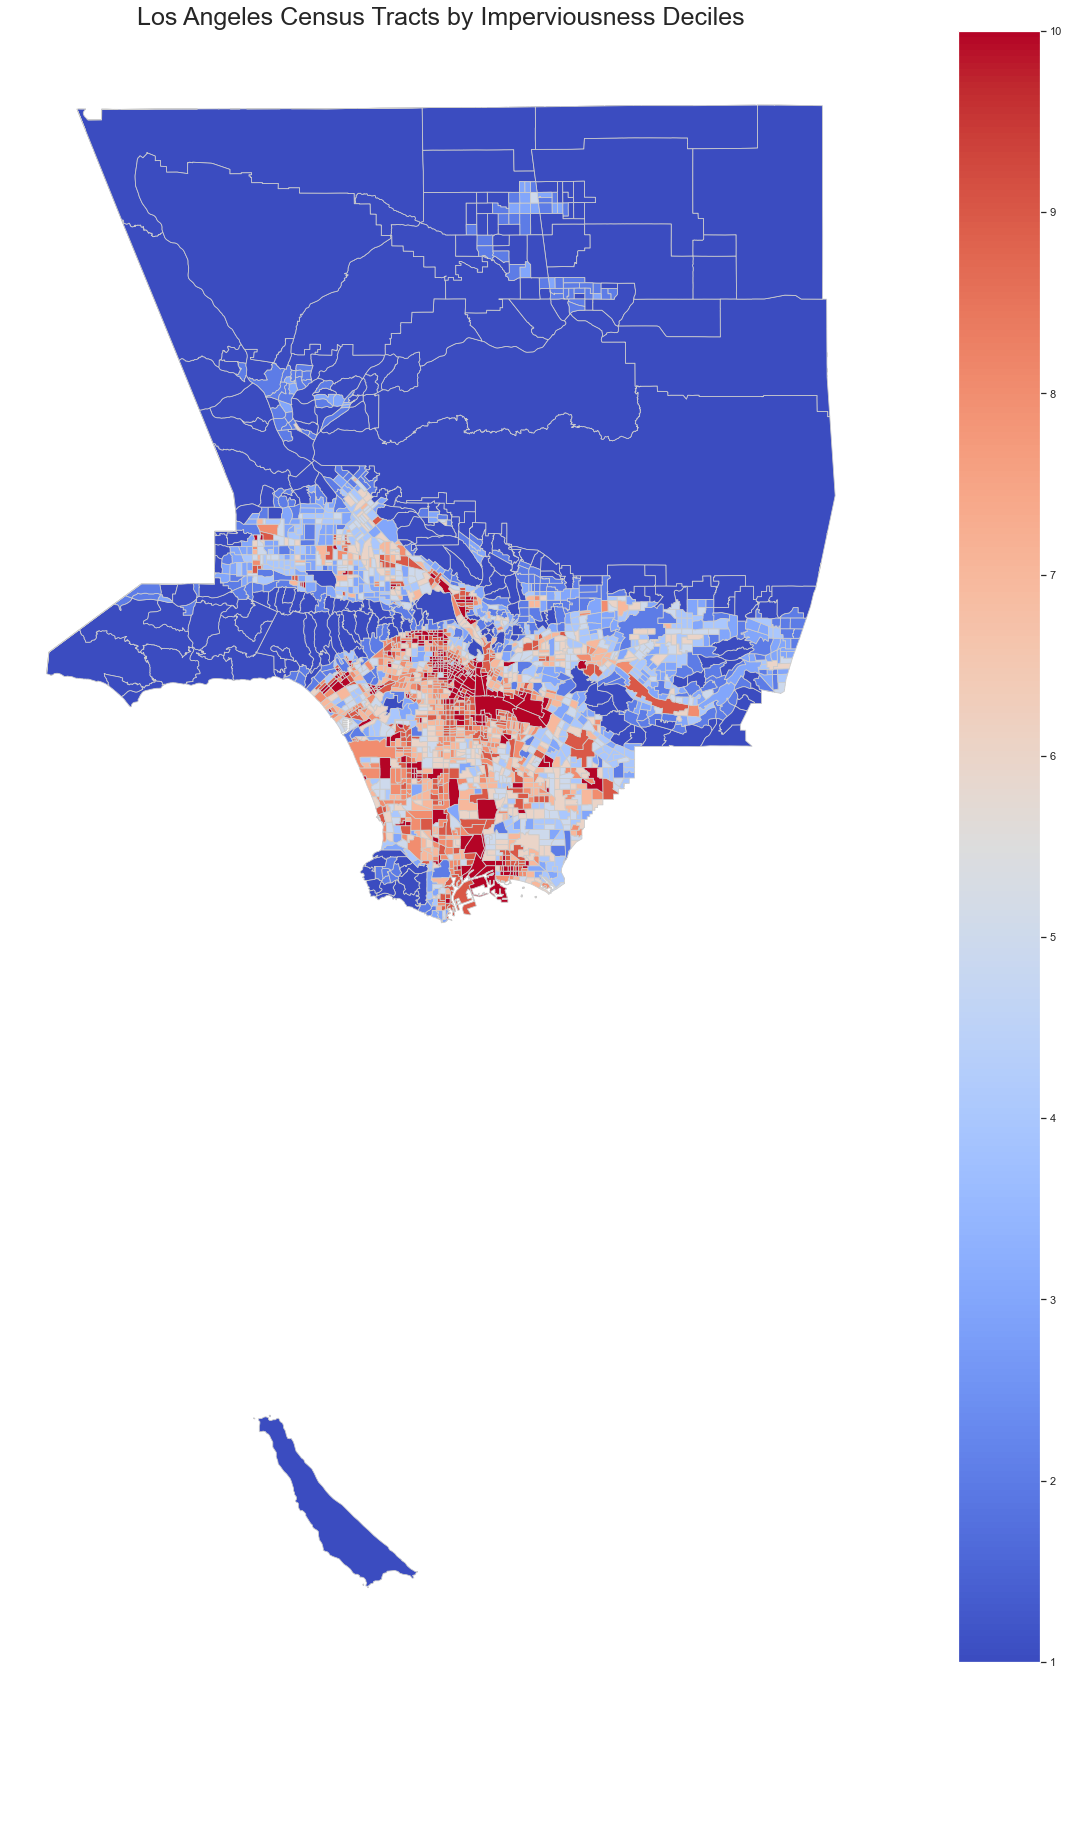

In [69]:
# set the value column that will be visualised
variable = 'impv_qcut10'

# set the range for the choropleth values
vmin, vmax = 1, 10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 30))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Los Angeles Census Tracts by Imperviousness Deciles', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Data Sources: MRLC.gov and https://healthyplacesindex.org/', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm)
# create map
cl_results0_areas.plot(column=variable, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')


In [70]:
priority_tracts = cl_results0_areas[(cl_results0_areas.impv_qcut10 > 9)]
priority_tracts['pop2010'].sum()/cl_results0_areas['pop2010'].sum()

0.0823790220712768

In [72]:
priority_tracts['area'].sum()

204.7454254216109

In [71]:
priority_zips = priority_tracts.groupby('ZIP').agg(['count', 'sum'])['area'].reset_index()
bar = pd.DataFrame(priority_zips.value_counts()).reset_index()
bar['ZIP'] = bar['ZIP'].round().astype(int)
bar.sort_values('count', ascending = False).head(15)

,ZIP,count,sum,0
38,90006,13,3.333738,1
37,90005,11,1.779773,1
47,90020,8,1.175658,1
25,90813,7,2.856069,1
51,90027,7,2.111475,1
65,90057,7,1.160193,1
21,90802,6,13.785546,1
12,90250,6,2.697382,1
9,90004,6,1.318008,1
39,90007,5,3.730243,1


Text(0.5, 1.0, 'Priority Zip Codes within 10th IMPV Decile')

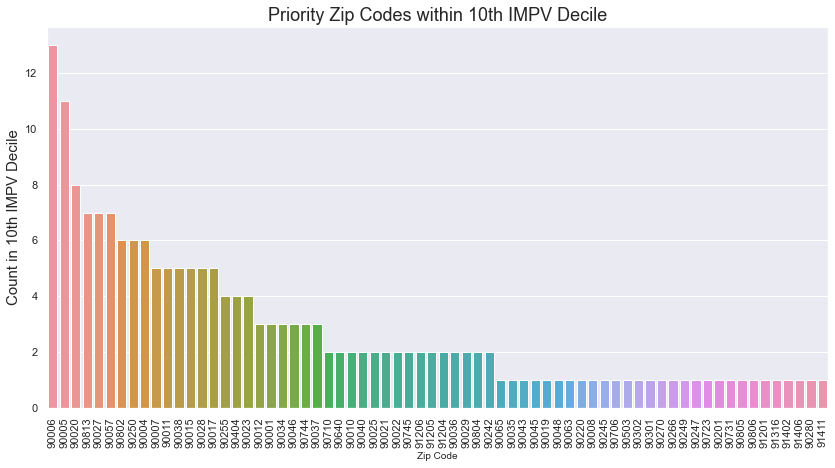

In [474]:
plt.figure(figsize=(14,7))
sns.barplot(data = bar, x = 'ZIP',y = 'count', order=bar.sort_values('count', ascending = False).ZIP)
ax.set_ylim(bottom = 4, top = 14)
plt.xlabel('Zip Code', size=10)
plt.xticks(rotation=90)
plt.ylabel('Count in 10th IMPV Decile', size=15)
plt.title('Priority Zip Codes within 10th IMPV Decile', size=18)